# Explainable AI for Classification with YOLOv8 and EigenCAM

In [ ]:
#!/usr/bin/env python
# -*-coding:utf-8 -*-
"""
  ████
██    ██   Datature
  ██  ██   Powering Breakthrough AI
    ██

@File    :   eigencam_yolov8_cls.ipynb
@Author  :   Wei Loon Cheng
@Version :   1.0
@Contact :   hello@datature.io
@License :   Apache License 2.0
@Desc    :   Explainable AI for Classification with YOLOv8 and EigenCAM
"""

In [1]:
%pip install -U datature
%pip install dill
%pip install ttach
%pip install ultralytics
%pip install torch

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os

import cv2
from datature.nexus import Client
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
from yolov8_cam.eigen_cam import EigenCAM
from yolov8_cam.utils.image import show_cam_on_image

### Load YOLOv8-Nano Classification Model

The sample YOLOv8 model used to show the visualization results in the following cells is a human action classifier trained on [Datature Nexus](https://www.datature.io/nexus). We use Datature Python SDK to export the model and download it to the local filesystem.

You can load your own YOLOv8 model trained on Datature Nexus by providing your [project secret key](https://dash.readme.com/project/datature/v1.0/docs/hub-and-api) and modifying the workflow title.

In [ ]:
client = Client("YOUR_PROJECT_SECRET_KEY")
project = client.get_project("YOUR_PROJECT_ID")
workflow_title = "YOUR_WORKFLOW_TITLE"

## Obtain an artifact id from Nexus, in this case, we assume that there is only one artifact
all_artifacts = project.artifacts.list()
artifact = [
    artifact for artifact in all_artifacts
    if artifact["flow_title"] == workflow_title
][-1]
artifact_id = artifact["id"]

# Export a model to the specified model format for specified artifact id
# This function will return an 409 if an export is already in progress,
# or if an export of the same format already exists.
try:
    export_options = {
        "format": "PyTorch"
    }
    project.artifacts.create_export(artifact_id, export_options)
except Exception as err:
    print(err.message)

In [ ]:
# Retrieve model metadata containing the download url
all_models = project.artifacts.list_exported_models(artifact_id)
model_metadata = [
    model for model in all_models if model["format"] == "PyTorch"
][-1]

# Download and unzip the model
model_dir = "./models/"
project.artifacts.download_exported_model(model_metadata["id"], model_dir)

In [ ]:
model_filename = [
    filename for filename in os.listdir(model_dir)
    if filename.endswith("yolov8n.pt")
][-1]
print(model_filename)
model = YOLO(os.path.join(model_dir, model_filename))

In [3]:
# Use the default COCO pretrained model for the following demo
model = YOLO("yolov8n-cls.pt")

100%|██████████| 5.28M/5.28M [00:02<00:00, 2.60MB/s]


### Read and preprocess image

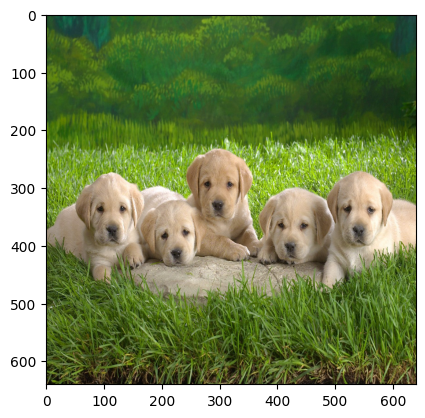

In [2]:
img = cv2.imread('images/puppies.jpg')
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

### Select target layer for feature extraction

Different model architectures tend to utilize different layer activations, so you will need to adjust accordingly if you are using a custom model.

In [4]:
target_layers = [model.model.model[-2]]


0: 224x224 golden_retriever 0.41, Labrador_retriever 0.30, Great_Pyrenees 0.09, kuvasz 0.04, cocker_spaniel 0.03, 24.5ms
Speed: 2.5ms preprocess, 24.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


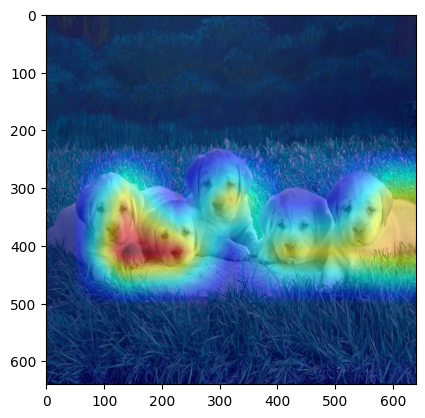

In [5]:
cam = EigenCAM(model, target_layers, task='cls')
grayscale_cam = cam(
    rgb_img,
    eigen_smooth=True,
)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()